## Building Network Models
# UB Species-collectors Network
### Projections

In [1]:
# Setting paths
import sys,os
import pathlib
sys.path.insert(0,os.path.expanduser('~/caryocar'))
sys.path.insert(0,os.path.abspath('..'))

In [2]:
# Building the networks from data
from setupmodels import scn
from setupmodels import occs
from setupmodels import ni

In [3]:
# Importing libraries for analysis
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.rc('figure', figsize=(10,6))

In [4]:
graphsdir = os.path.abspath('./graphs')

if not os.path.isdir(graphsdir):
    !mkdir graphs

---

## The SCN Network

In [5]:
print(nx.info(scn))
print('Number of species nodes:',len(scn.listSpeciesNodes()))
print('Number of collectors nodes:',len(scn.listCollectorsNodes()))

Name: 
Type: SpeciesCollectorsNetwork
Number of nodes: 22112
Number of edges: 142647
Average degree:  12.9022
Number of species nodes: 15344
Number of collectors nodes: 6768


---

## Obtaining taxonomic aggregations

#### Aggregation by family

In [6]:
g = dict( occs[['family','species']].groupby('family').apply(lambda g: set(g['species'])) )

In [7]:
scn_family = scn.taxonomicAggregation(g)

In [8]:
print(nx.info(scn_family))
print('Number of species nodes:',len(scn_family.listSpeciesNodes()))
print('Number of collectors nodes:',len(scn_family.listCollectorsNodes()))

Name: 
Type: SpeciesCollectorsNetwork
Number of nodes: 7242
Number of edges: 43803
Average degree:  12.0969
Number of species nodes: 474
Number of collectors nodes: 6768


#### Aggregation by genus

In [9]:
g = dict( occs[['genus','species']].groupby('genus').apply(lambda g: set(g['species'])) )

In [10]:
scn_genus = scn.taxonomicAggregation(g)

In [11]:
print(nx.info(scn_genus))
print('Number of species nodes:',len(scn_genus.listSpeciesNodes()))
print('Number of collectors nodes:',len(scn_genus.listCollectorsNodes()))

Name: 
Type: SpeciesCollectorsNetwork
Number of nodes: 9937
Number of edges: 87632
Average degree:  17.6375
Number of species nodes: 3169
Number of collectors nodes: 6768


---

## Bipartite projections

* The density of projected networks increase when aggregating them on higher taxonomic ranks.
* Species projections are denser than collectors projections, although the absolute number of edges in species projections (aggregated by genus and family) is lower than in collectors.

### Collectors projections

The number of nodes in SCN collectors projections does not change with successive taxonomic aggregations, but the number of edges does! The number of edges (and consequently graph density) increases for taxonomic aggregations on higher ranks.

In [12]:
# Non-aggregated SCN
scn_projCol = scn.project('collectors',rule='cosine_similarity')

In [13]:
print(nx.info(scn_projCol))
print('Density:',nx.density(scn_projCol))

Name: 
Type: Graph
Number of nodes: 6768
Number of edges: 834239
Average degree: 246.5245
Density: 0.03643040153491373


In [14]:
# Genus aggregated SCN
scn_genus_projCol = scn_genus.project('collectors',rule='cosine_similarity')

In [15]:
print(nx.info(scn_genus_projCol))
print('Density:',nx.density(scn_genus_projCol))

Name: 
Type: Graph
Number of nodes: 6768
Number of edges: 2509837
Average degree: 741.6776
Density: 0.10960212804386187


In [16]:
# Family aggregated SCN
scn_family_projCol = scn_family.project('collectors',rule='cosine_similarity')

In [17]:
print(nx.info(scn_family_projCol))
print('Density:',nx.density(scn_family_projCol))

Name: 
Type: Graph
Number of nodes: 6768
Number of edges: 5431799
Average degree: 1605.1415
Density: 0.23720135192306147


### Species projections

Non-aggregated SCN species projections have lower density than their aggregated counterparts, although the number of nodes (and specially edges) is much greater. Thus, they become computationally hard to deal with.

The number of nodes and edges in SCN species projections aggregated on higher ranks are reduced, although the network density increases, making it harder to obtain relevant relationships without filtering.

In [18]:
# Non-aggregated SCN
scn_projSp = scn.project('species',rule='cosine_similarity')

In [19]:
print(nx.info(scn_projSp))
print('Density:',nx.density(scn_projSp))

Name: 
Type: Graph
Number of nodes: 15344
Number of edges: 19482923
Average degree: 2539.4842
Density: 0.1655141907295104


In [20]:
# Genus aggregated SCN
scn_genus_projSp = scn_genus.project('species',rule='cosine_similarity')

In [21]:
print(nx.info(scn_genus_projSp))
print('Density:',nx.density(scn_genus_projSp))

Name: 
Type: Graph
Number of nodes: 3169
Number of edges: 1188065
Average degree: 749.8044
Density: 0.23668066751452677


In [22]:
# Family aggregated SCN
scn_family_projSp = scn_family.project('species',rule='cosine_similarity')

In [23]:
print(nx.info(scn_family_projSp))
print('Density:',nx.density(scn_family_projSp))

Name: 
Type: Graph
Number of nodes: 474
Number of edges: 43756
Average degree: 184.6245
Density: 0.39032658049437563


---

## Threshold vs. Density (family vs genus aggregations)

### Collectors projections

In [24]:
m_scn_family_projCol = nx.adjacency_matrix(scn_family_projCol)
m_scn_genus_projCol = nx.adjacency_matrix(scn_genus_projCol)
m_scn_noagg_projCol = nx.adjacency_matrix(scn_projCol)

In [25]:
calculateDensity = lambda m: len(m.data)/np.prod(m.shape) # calculates the density of a sparse matrix

from copy import deepcopy
def filterMatrix(m,thresh):
    # Filters a sparse matrix given a threshold 
    m_filtered = deepcopy(m)
    m_filtered.data = np.where(m_filtered.data >= thresh, m_filtered.data, 0)
    m_filtered.eliminate_zeros()
    return m_filtered

In [88]:
# X = np.logspace(-3,0) # threshold values increasing in a log scale
X = np.linspace(0,1,35) # threshold values increasing in a linear scale
y_noagg = np.array( [ calculateDensity(filterMatrix(m_scn_noagg_projCol,thresh)) for thresh in X ] )
y_genus = np.array( [ calculateDensity(filterMatrix(m_scn_genus_projCol,thresh)) for thresh in X ] )
y_family = np.array( [ calculateDensity(filterMatrix(m_scn_family_projCol,thresh)) for thresh in X ] )

Text(0,0.5,'Matrix Density')

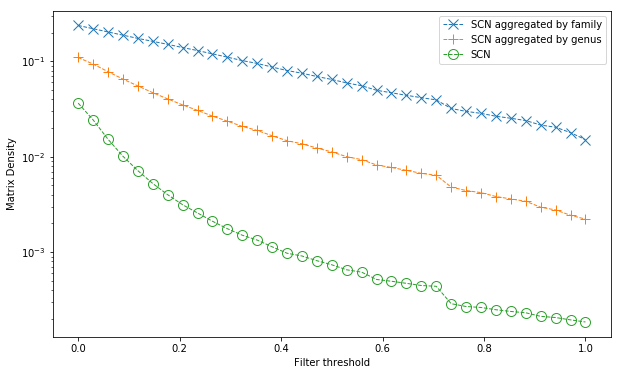

In [89]:
plt.plot(X,y_family, 'x', ls='--', markerfacecolor='none', label='SCN aggregated by family',markersize=10,lw=1)
plt.plot(X,y_genus, '+', ls='--', markerfacecolor='none', label='SCN aggregated by genus', markersize=10,lw=1)
plt.plot(X,y_noagg, 'o', ls='--', markerfacecolor='none', label='SCN', markersize=10,lw=1)

plt.yscale('log')

plt.legend()
plt.xlabel('Filter threshold')
plt.ylabel('Matrix Density')
#plt.savefig('filter_thresh.pdf', dpi=92, bbox_inches='tight')

From the figure above we can detect a peak of density decayment around threshold value of $0.7$.

Especially for non-aggregated SCN, density decays faster for threshold values between $0$ and $0.4$. This is not apparent in the SCN aggregated by family (decays exponentially).

## SCN $S_{col}$ projection: Looking at the graph

We improve the visualization by doing the following routine:
* We start with a `scn_family` aggregation;
* Filter out edges with count < 20 and then remove isolated nodes (k=0);
* Get the projection with similarity threshold of 0.8;
* Obtain subgraphs, and filter out those with less than 500 records.


In [5]:
scn_family = scn.taxonomicAggregation( dict( occs[['family','species']].groupby('family').apply(lambda g: set(g['species'])) ) )

In [6]:
scn_family.remove_edges_from([ (u,v) for u,v,cnt in scn_family.edges(data='count') if cnt<20 ])
scn_family.remove_nodes_from( [ n for n,k in scn_family.degree() if k==0 ] )

In [7]:
g=scn_family.project('collectors','cosine_similarity',thresh=0.8)

In [8]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 515
Number of edges: 8497
Average degree:  32.9981


In [9]:
score_component = lambda g: sum( cnt for n,cnt in g.nodes(data='count') )

In [10]:
subgraphs = sorted([ (gr,score_component(gr)) for gr in nx.connected_component_subgraphs(g) ], key=lambda x:x[1], reverse=True)

In [11]:
subgraphs = [ g for g, score in filter( lambda x: x[1]>=500, subgraphs) ]

In [12]:
subgraphs

In [13]:
g = nx.compose_all(subgraphs)

In [14]:
print(nx.info(g))

Name: compose( ,  )
Type: Graph
Number of nodes: 457
Number of edges: 8480
Average degree:  37.1116


## Communities

In [15]:
import community

In [24]:
parts = community.best_partition(g, resolution=1)

In [25]:
nx.set_node_attributes(g,parts,'community')

In [26]:
nx.write_gexf(g,os.path.join(graphsdir,'scn_family_projCol_communities.gexf'))

### What is the families signature of each community?

In [27]:
communities = set( com for n,com in g.nodes(data='community'))

In [28]:
communities = [ (c, [n for n,c1 in g.nodes(data='community') if c1==c ] ) for c in communities ]

In [29]:
def merge_dicts(dicts):
    d_res = dict()
    for dic in dicts:
        for k in dic.keys():
            d_res[k] = d_res.get(k,0) + dic[k]
    return d_res

def count_spp_per_collector(col):
    spp,sprs = scn_family.getSpeciesBag(col)
    counts = sprs.data
    species = [spp[i] for i in sprs.indices]
    return dict( i for i in zip(species,counts) ) 

def comm_taxonomic_composition(taxa_dict):
    # Returns percentages
    total = sum(taxa_dict.values())
    d = dict()
    for k,v in taxa_dict.items():
        d[k]=v/total
    return d

In [30]:
comm_taxa = [ (comm_id, comm_taxonomic_composition(merge_dicts([count_spp_per_collector(col) for col in comm_cols]))) for comm_id, comm_cols in communities] 

In [31]:
[ (com, sorted(dict_taxa.items(), key=lambda x:x[1],reverse=True)[:5]) for com,dict_taxa in comm_taxa ]

[(0,
  [('Asteraceae', 0.7272371255140004),
   ('Fabaceae', 0.09124730761699627),
   ('Melastomataceae', 0.05247699236342275),
   ('Myrtaceae', 0.030350499314666143),
   ('Cyperaceae', 0.028784021930683374)]),
 (1,
  [('Cyperaceae', 0.5042951971885982),
   ('Fabaceae', 0.0987895353377587),
   ('Oxalidaceae', 0.0720421710269426),
   ('Asteraceae', 0.052713783678250685),
   ('Poaceae', 0.050761421319796954)]),
 (2,
  [('Fabaceae', 0.5884750787474523),
   ('Myrtaceae', 0.08634426533259218),
   ('Rubiaceae', 0.06021863998517695),
   ('Asteraceae', 0.0474337594960163),
   ('Bignoniaceae', 0.029460811561978877)]),
 (3,
  [('Poaceae', 0.40428082191780823),
   ('Cyperaceae', 0.1254280821917808),
   ('Asteraceae', 0.07542808219178082),
   ('Fabaceae', 0.07054794520547945),
   ('Eriocaulaceae', 0.0586472602739726)]),
 (4,
  [('Myrtaceae', 0.6198587819947043),
   ('Fabaceae', 0.07749338040600176),
   ('Asteraceae', 0.04324801412180053),
   ('Poaceae', 0.03468667255075022),
   ('Bignoniaceae', 0.0

---

## SCN $S_{sp}$ projection

In [71]:
g=scn_family.project('species','cosine_similarity',thresh=0.8)

In [50]:
g.remove_nodes_from([ n for n,cnt in g.nodes(data='count') if cnt<10 ])

In [72]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 474
Number of edges: 1290
Average degree:   5.4430


In [84]:
subgraphs = sorted([ (gr,score_component(gr)) for gr in nx.connected_component_subgraphs(g) ], key=lambda x:x[1], reverse=True)

In [85]:
subgraphs = [ g for g, score in filter( lambda x: x[1]>=600, subgraphs) ]

In [86]:
subgraphs

In [87]:
g = nx.compose_all(subgraphs)

In [88]:
nx.write_gexf(g,'g.gexf')

---

In [113]:
from copy import deepcopy

In [166]:
scn2_family = deepcopy(scn_family)

In [149]:
print(nx.info(scn2_family))

Name: 
Type: SpeciesCollectorsNetwork
Number of nodes: 7242
Number of edges: 43803
Average degree:  12.0969


In [167]:
scn2_family.remove_edges_from([ (u,v) for u,v,cnt in scn2_family.edges(data='count') if cnt <20 ])

In [168]:
scn2_family.remove_nodes_from([ n for n,k in scn2_family.degree() if k==0 ])

In [169]:
print(nx.info(scn2_family))

Name: 
Type: SpeciesCollectorsNetwork
Number of nodes: 679
Number of edges: 2056
Average degree:   6.0560


In [179]:
g = dict( occs[['family','species']].groupby('family').apply(lambda g: set(g['species'])) )
scn2_family = scn2.taxonomicAggregation(g)

In [183]:
g=scn2_family.project('collectors','cosine_similarity',thresh=0.85)

In [185]:
g.remove_nodes_from([ n for n,cnt in g.nodes(data='count') if cnt<10 ])

In [188]:
score_component = lambda g: sum( cnt for n,cnt in g.nodes(data='count') )

In [189]:
subgraphs = sorted([ (gr,score_component(gr)) for gr in nx.connected_component_subgraphs(g) ], key=lambda x:x[1], reverse=True)

In [190]:
subgraphs = [ g for g, score in filter( lambda x: x[1]>=1000, subgraphs) ]

In [191]:
g = nx.compose_all(subgraphs)

In [193]:
print(nx.info(g))

Name: compose( ,  )
Type: Graph
Number of nodes: 893
Number of edges: 17237
Average degree:  38.6047


In [194]:
nx.write_gexf(g,'g.gexf')

In [125]:
# project

In [133]:
g = scn2_family.project('collectors','cosine_similarity',thresh=0.85)

In [129]:
print(nx.info(scn2_family_projCol))

Name: 
Type: Graph
Number of nodes: 5516
Number of edges: 581115
Average degree: 210.7016


In [ ]:
nx.write_gexf(scn2_family_projCol,)